# Substract volumes of spheres

Given two spheres $S_1$ and $S_2$ with respective radii $R_1$ and $R_2$ and with centers $d$ units apart, we want to find the volume of the region of $S_2$ that is outside $S_1$.

Calculations are based on this formulas for the volume of the spherical pole caps: https://en.wikipedia.org/wiki/Spherical_cap#Volume_and_surface_area

In [1]:
from math import pi

In [2]:
def cap(r, h):
    """volume of the polar cap of the sphere with radius r and cap height h"""
    return pi * (3 * r - h) * h ** 2 / 3

def vol(r):
    """volume of sphere with radius r"""
    return 4 * pi * r ** 3 / 3

In [3]:
# test
assert(cap(1, 0) == 0)
assert(cap(1, 2) == vol(1))

## Main Case 1: Center of S2 outside of S1

wlog. we can assume

$r_1^2 - (r_1-h_1)^2 = r_2^2 - (r_2-h_2)^2$

but we also know that

$(r_1 - h_1) + (r_2 - h_2) = d$ **(case 1)**

which leads us to

$r_1^2 - (r_1-h_1)^2 = r_2^2 - (d - r_1 + h_1)^2$

let's then solve for the unknown $t$ in

$r_1^2 - (r_1-t)^2 = r_2^2 - (d - r_1 + t)^2$

First,

$r_1^2 - (r_1-t)^2 = (r_1 + r_1 - t)(r_1 - r_1 + t) = (2r_1 - t)t = 2r_1t - t^2$

Second,

$r_2^2 - (d - r_1 + t)^2 = r_2^2 - (d - r_1)^2 - 2(d - r_1)t - t^2$

Putting them together

$2r_1t = r_2^2 - (d - r_1)^2 - 2(d - r_1)t$

whence

$t = (r_2^2 - (d - r_1)^2) / 2d$

## Main Case 2: Center of S2 inside of S1

wlog. we can assume

$r_1^2 - (r_1-h_1)^2 = r_2^2 - (r_2-h_2)^2$

but we also know that

$(r_1 - h_1) - (r_2 - h_2) = d$ **(case 2)**

which leads us to

$r_1^2 - (r_1-h_1)^2 = r_2^2 - (r_1 - h_1 - d)^2$

let's then solve for the unknown $t$ in

$r_1^2 - (r_1-t)^2 = r_2^2 - (r_1 - d - t)^2$

First,

$r_1^2 - (r_1-t)^2 = (r_1 + r_1 - t)(r_1 - r_1 + t) = (2r_1 - t)t = 2r_1t - t^2$

Second,

$r_2^2 - (r_1 - d - t)^2 = r_2^2 - (r_1 - d)^2 + 2(r_1 - d)t - t^2$

Putting them together

$2r_1t = r_2^2 - (r_1 - d)^2 + 2(r_1-d)t$

whence

$t = (r_2^2 - (r_1 - d)^2) / 2d$


In [4]:
def s2_minus_s1(r1, r2, d):
    
    """
    volume of S2 outside of S1
    r1: radius of S1
    r2: radius of S2
    d: distance between center of S1 and center of S2
    """
    
    if d > r1 + r2:       # S1 and S2 not in contact
        
        #print("S1 and S2 not in contact")
        return vol(r2)    
    
    elif (r2 > d + r1):   # S1 sits inside S2
        
        #print("S1 sits inside S2")
        return vol(r2) - vol(r1)
        
    elif (r1 > d + r2):   # S2 sits inside S1 
        
        #print("S2 sits inside S1")
        return 0.
    
    elif d > r1:          # center of S2 is outside S1
        
        h1 = (r2 ** 2 - (d - r1) ** 2) / (2 * d)
        h2 = r1 - h1 + r2 - d
        
        #print("center of S2 is outside S1")
        return vol(r2) - cap(r1, h1) - cap(r2, h2)
    
    elif d <= r1:         # center of S2 is inside S1
        
        h1 = (r2 ** 2 - (r1 - d) ** 2) / (2 * d)
        h2 = d - r1 + h1 + r2
        
        #print("center of S2 is inside S1")
        return cap(r2, h2) - cap(r1, h1)

# Apply to CMAPs

In [5]:
import pandas as pd
import numpy as np
from Bio.PDB.PDBParser import PDBParser

In [10]:
pdb_dir = "/workspace/projects/clustering_3d/clustering_3d/datasets/pdb_structures"
pae_dir = "/workspace/projects/clustering_3d/clustering_3d/datasets/pae"
cmap_dir = "/workspace/projects/clustering_3d/clustering_3d/datasets/cmaps"
seq_df = "/workspace/projects/clustering_3d/clustering_3d/datasets/seq_for_mut_prob.csv"
seq_df = pd.read_csv(seq_df)

uniprot_to_gene_dict = {uni_id : gene for gene, uni_id in seq_df[["Gene", "Uniprot_ID"]].drop_duplicates().values}

In [61]:
uni_id = "P04637"

# Load cmap and PAE
#cmap = np.load(f"{cmap_dir}/{uni_id}-F1.npy")
pae = np.load(f"{pae_dir}/{uni_id}-F1-predicted_aligned_error.npy")
m = np.load(f"/workspace/projects/clustering_3d/clustering_3d/datasets/prob_cmaps/{uni_id}-F1.npy")

# PDB
pdb_dir = "/workspace/projects/clustering_3d/clustering_3d/datasets_backup/datasets_distances/pdb_structures"
path_pdb = f"{pdb_dir}/AF-{uni_id}-F1-model_v4.pdb"
structure = get_structure(path_pdb)
dmap = get_dist_matrix(structure["A"])
cmap = dmap < 10
cmap = cmap.astype(int)

r1 = threshold for contact (e.g., the radius of the sphere of the res volume)  
r2 = the radius of the error sphere, which corresponds to the PAE (where the center of res 2 could be located)  
d = distance between res1 and res2

In [19]:
def get_prob_contact(pae, dmap, res_x, res_y, d_thr=10):
    
    if res_x == res_y:   
        
        return 1
    
    else:
        # Get the volume of res2 outside of res1
        vol_s2_out_s1 = s2_minus_s1(r1=d_thr, r2=pae[res_x, res_y], d=dmap[res_x, res_y])

        # Get the probability that s2 is out of s1
        p_s2_in_s1 = vol_s2_out_s1 / vol(pae[res_x, res_y])
        
        return 1 - p_s2_in_s1

get_prob_contact(pae, dmap, 5, 11)

0.22768096841112728

In [20]:
from tqdm import tqdm

In [21]:
%%time

m = np.zeros((len(pae), len(pae)))

for x in range(len(pae)):
    
    for y in range(len(pae)):
        
        m[x, y] = get_prob_contact(pae, dmap, x, y)

CPU times: user 180 ms, sys: 3.48 ms, total: 183 ms
Wall time: 180 ms


In [73]:
m

array([[1.00000000e+00, 1.00000000e+00, 9.94852858e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.94852858e-01, 1.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.59325796e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

## Try to compute everything in one go
* Compute distance, compute probability, store


In [22]:
def get_structure(file):
    """
    Use Bio.PDB to parse protein structure.
    """
    id = file.split("AF-")[1].split("-model_v1")[0]
    return PDBParser().get_structure(id=id, file = f"{file}")[0]


def get_dist_matrix(chain) :
    """
    Compute the distance matrix between C-alpha of a protein.
    """
    m = np.zeros((len(chain), len(chain)), float)
    for i, res1 in enumerate(chain) :
        for j, res2 in enumerate(chain) :
            m[i, j] = abs(res1["CA"] - res2["CA"])
    return m

In [23]:

def get_structure(file):
    """
    Use Bio.PDB to parse protein structure.
    """
    id = file.split("AF-")[1].split("-model_v1")[0]
    return PDBParser().get_structure(id=id, file = f"{file}")[0]


In [24]:
def get_prob_contact(pae_value, dmap_value, d_thr=10):

    if pae_value == 0 and dmap_value == 0:
        
        return 1
    
    else:
    
        # Get the volume of res2 outside of res1
        vol_s2_out_s1 = s2_minus_s1(r1=d_thr, r2=pae_value, d=dmap_value)

        # Get the probability that s2 is out of s1
        p_s2_in_s1 = vol_s2_out_s1 / vol(pae_value)

        return 1 - p_s2_in_s1

In [42]:
%%time

d_thr = 10
chain = get_structure(path_pdb)["A"]

m = np.zeros((len(chain), len(chain)), float)
    
for i, res1 in enumerate(chain):
    for j, res2 in enumerate(chain):
        
        d = abs(res1["CA"] - res2["CA"])
        
        m[i, j] = get_prob_contact2(pae[i, j], d, d_thr)

CPU times: user 362 ms, sys: 0 ns, total: 362 ms
Wall time: 360 ms


In [43]:
%%time

m = get_prob_cmap(chain, pae, d_thr=10)

CPU times: user 396 ms, sys: 35.1 ms, total: 431 ms
Wall time: 380 ms


In [30]:
def get_prob_cmap(chain, pae, d_thr=10) :
    """
    Compute the probabilities that each pair of residue in a protein are 
    in contact taking into account the Predicted Aligned Error (PAE) and 
    the PDB structure predicted by AlphaFold 2
    """
    
    m = np.zeros((len(chain), len(chain)), float)
    
    for i, res1 in enumerate(chain):
        for j, res2 in enumerate(chain):

            d = abs(res1["CA"] - res2["CA"])
            m[i, j] = get_prob_contact(pae[i, j], d, d_thr)
            
    return m

In [45]:
# %%time

# m = np.zeros((len(pae), len(pae)))

# for x in range(len(pae)):
    
#     for y in range(len(pae)):
        
#         m[x, y] = get_prob_contact(pae, dmap, x, y)

## End

In [31]:
def get_prob_contact2(pae_value, dmap_value, d_thr=10):

    if pae_value == 0 and dmap_value == 0:
        
        return 1
    
    else:
    
        # Get the volume of res2 outside of res1
        vol_s2_out_s1 = s2_minus_s1(r1=d_thr, r2=pae_value, d=dmap_value)

        # Get the probability that s2 is out of s1
        p_s2_in_s1 = vol_s2_out_s1 / vol(pae_value)

        return 1 - p_s2_in_s1
    
    
# Apply the function to each corresponding element using np.nditer()
result = np.array(list(map(get_prob_contact2, np.nditer(pae), np.nditer(dmap))))
result = result.reshape(pae.shape)

In [32]:
%%time

# Apply the function to each corresponding element using np.nditer()
result = np.array(list(map(get_prob_contact2, np.nditer(pae), np.nditer(dmap))))
result = result.reshape(pae.shape)

CPU times: user 264 ms, sys: 877 µs, total: 264 ms
Wall time: 262 ms


In [26]:
result[:5, :5]

array([[1.        , 1.        , 0.99998492, 0.36600964, 0.09557134],
       [1.        , 1.        , 1.        , 1.        , 0.47698975],
       [0.99998492, 1.        , 1.        , 1.        , 1.        ],
       [0.37400341, 1.        , 1.        , 1.        , 1.        ],
       [0.06208045, 0.47698975, 0.9689974 , 1.        , 1.        ]])

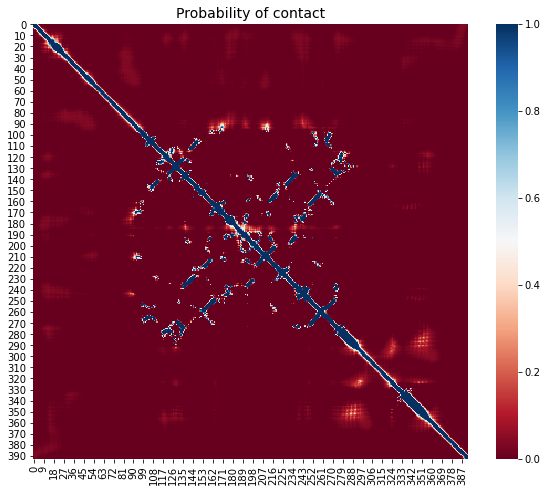

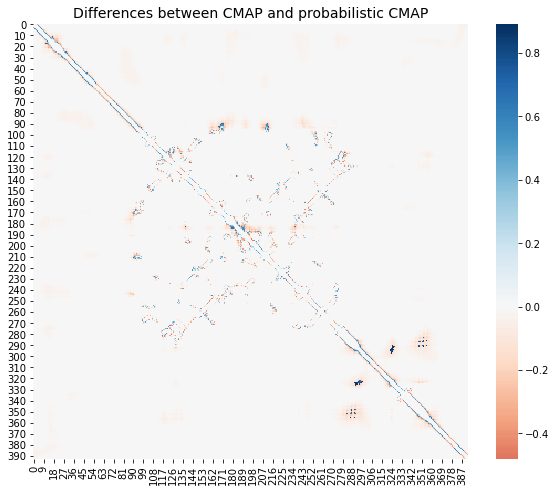

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="RdBu", square=True)
plt.title("Probability of contact", fontsize=14)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cmap-m, cmap="RdBu", square=True, center=0)
plt.title("Differences between CMAP and probabilistic CMAP", fontsize=14)
plt.show()

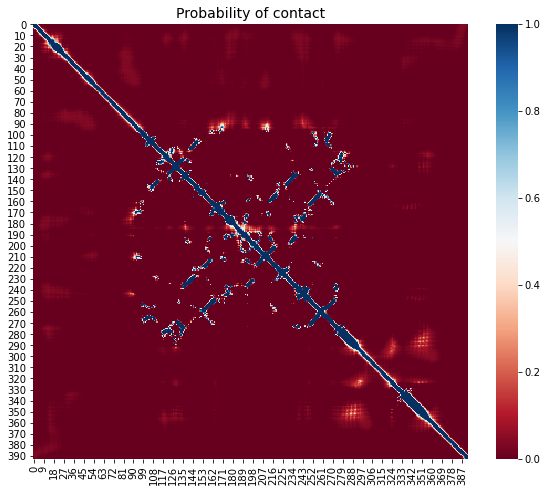

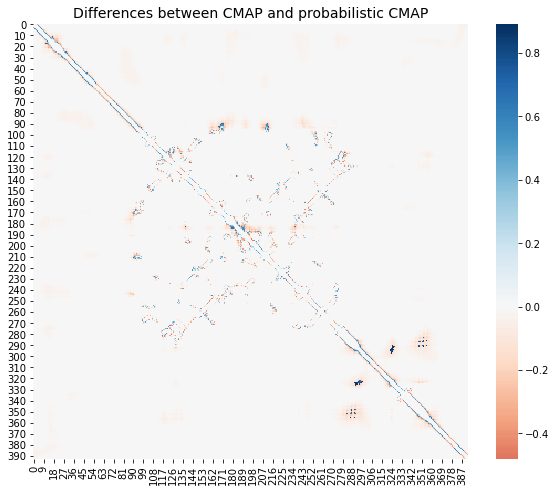

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="RdBu", square=True)
plt.title("Probability of contact", fontsize=14)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cmap-m, cmap="RdBu", square=True, center=0)
plt.title("Differences between CMAP and probabilistic CMAP", fontsize=14)
plt.show()

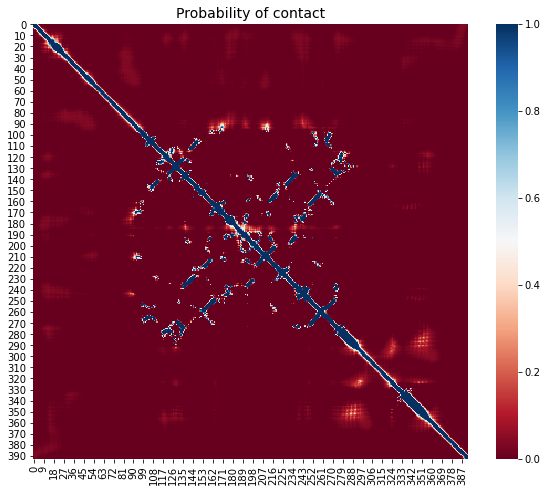

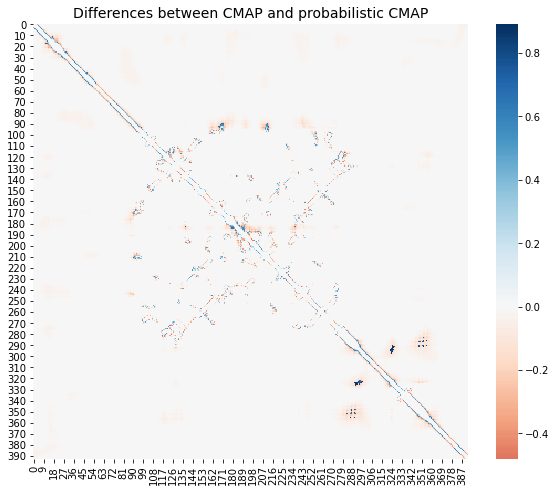

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="RdBu", square=True)
plt.title("Probability of contact", fontsize=14)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cmap-m, cmap="RdBu", square=True, center=0)
plt.title("Differences between CMAP and probabilistic CMAP", fontsize=14)
plt.show()

In [87]:
np.round(np.linspace(1,393,10)).astype(int)

array([  1,  45,  88, 132, 175, 219, 262, 306, 349, 393])

In [90]:
pd.DataFrame(dmap)

,0,1,2,3,4,5,6,7,8,9,...,383,384,385,386,387,388,389,390,391,392
0,0.000000,3.849607,7.011268,10.290317,13.180148,16.412903,19.736103,22.696609,25.758875,27.044165,...,33.712631,30.364956,29.321642,25.656063,24.778049,22.326582,22.436350,23.785458,24.624660,27.489771
1,3.849607,0.000000,3.839364,6.559415,9.507117,12.886015,16.045223,19.148199,22.146156,23.613298,...,33.123383,29.640078,28.826725,25.350288,24.701685,22.753889,23.189445,24.931078,26.241110,29.334225
2,7.011268,3.839364,0.000000,3.871581,6.676369,9.523830,12.977454,15.988514,18.879238,20.054888,...,30.186377,26.616304,25.916134,22.617062,22.152643,20.668287,21.451042,23.607195,25.391409,28.710470
3,10.290317,6.559415,3.871581,0.000000,3.850540,6.860125,9.784039,13.202044,15.856828,17.376526,...,31.420946,27.782127,27.286325,24.289455,23.975218,22.986568,23.891884,26.179737,28.214197,31.581837
4,13.180148,9.507117,6.676369,3.850540,0.000000,3.848319,6.613822,9.695702,12.728885,14.595935,...,30.488659,26.952726,26.971497,24.279020,24.533260,24.013775,25.436939,28.117546,30.413336,33.906391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,22.326582,22.753889,20.668287,22.986568,24.013775,23.425301,26.742109,27.696323,29.328453,27.605913,...,15.651591,12.933669,9.910023,6.628014,3.833493,0.000000,3.718956,7.503061,10.594290,13.970041
389,22.436350,23.189445,21.451042,23.891884,25.436939,25.131273,28.515148,29.863003,31.424347,29.768267,...,18.921337,16.340519,13.019291,10.106271,6.693654,3.718956,0.000000,3.869486,7.173133,10.633675
390,23.785458,24.931078,23.607195,26.179737,28.117546,28.075159,31.497047,33.108135,34.637039,33.037670,...,22.156885,19.835920,16.355488,13.752401,10.249280,7.503061,3.869486,0.000000,3.577627,6.939185
391,24.624660,26.241110,25.391409,28.214197,30.413336,30.710115,34.234989,36.018559,37.694534,36.261539,...,25.016581,22.920397,19.499460,16.907112,13.583977,10.594290,7.173133,3.577627,0.000000,3.657658


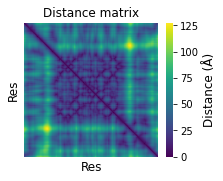

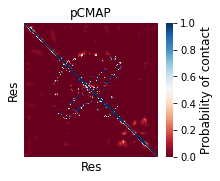

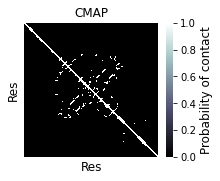

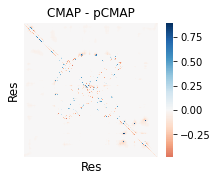

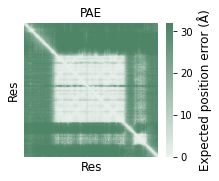

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(3, 3))
ax = sns.heatmap(dmap, cmap="viridis", square=True, 
                 xticklabels=False, yticklabels=False, cbar_kws={"shrink": .82})
cbar = ax.collections[0].colorbar
cbar.set_label('Distance (Å)', fontsize=12)
plt.xlabel("Res", fontsize=12)
plt.ylabel("Res", fontsize=12)
plt.title("Distance matrix", fontsize=12)
plt.savefig("distance_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(3, 3))
ax = sns.heatmap(m, cmap="RdBu", square=True, xticklabels=False, yticklabels=False, cbar_kws={"shrink": .82})
plt.title("pCMAP", fontsize=12)
cbar = ax.collections[0].colorbar
cbar.set_label('Probability of contact', fontsize=12)
plt.xlabel("Res", fontsize=12)
plt.ylabel("Res", fontsize=12)
plt.savefig("pcmap.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(3, 3))
ax = sns.heatmap(cmap, cmap="bone", square=True, xticklabels=False, yticklabels=False, cbar_kws={"shrink": .82})
plt.title("CMAP", fontsize=12)
cbar = ax.collections[0].colorbar
cbar.set_label('Probability of contact', fontsize=12)
plt.xlabel("Res", fontsize=12)
plt.ylabel("Res", fontsize=12)
plt.savefig("cmap.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cmap-m, cmap="RdBu", square=True, center=0, xticklabels=False, yticklabels=False, cbar_kws={"shrink": .82})
plt.title("CMAP - pCMAP", fontsize=12)
plt.xlabel("Res", fontsize=12)
plt.ylabel("Res", fontsize=12)
plt.savefig("diff_cmap_pcmap.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(3, 3))
ax = sns.heatmap(pae, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True).reversed(), 
            square=True, center=0, xticklabels=False, yticklabels=False, cbar_kws={"shrink": .82})
plt.title("PAE", fontsize=12)
cbar = ax.collections[0].colorbar
cbar.set_label('Expected position error (Å)', fontsize=12)
plt.xlabel("Res", fontsize=12)
plt.ylabel("Res", fontsize=12)
plt.savefig("pae.png", dpi=300, bbox_inches='tight')
plt.show()

anomaly_score_6.png    pcmap.png
anomaly_score.png      substract_spheres.ipynb
cmap.png	       Toy_example_method_comparison_05.png
diff_cmap_pcmap.png    Toy_example_method_comparison_07.png
distance_matrix.png    Toy_example_method_comparison_08.png
method_overview.ipynb  Toy_example_method_comparison_added_dots.png
pae.png		       Toy_example_method_comparison.png


In [ ]:
pae[5, 8]
vol(pae[8, 5])

904.7786842338604

In [31]:
get_prob_contact(r1=10, r2=pae[2,0], d=dm[2,0])

0.9982948551357972